### CIFAR10

In this notebook, we demonstrate how to compile a LITDataset from CIFAR10 data.

Note that the filepaths are imported from a `localpaths.py` module in this example.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pickle
import os
import json
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import tarfile
import xml
import sys

from io import BytesIO
from PIL import Image
from IPython import display

In [3]:
sys.path.append('..')
from litdata.writer import LITWriter
from litdata.litdata import LITDataset

In [4]:
from localpaths import CIFAR10_TAR_PATH, LITDATAPATH

In [5]:
tarfiledict = {}
with tarfile.open(CIFAR10_TAR_PATH, 'r') as tarfile:
    members = tarfile.getmembers()
    for member in members:
        if '_batch' in member.name:
            name = member.name.split('/')[-1]
            tarfiledict[name] = pickle.loads(tarfile.extractfile(member).read(), encoding='bytes')
        elif 'meta' in member.name:
            name = member.name.split('/')[-1]
            meta = pickle.loads(tarfile.extractfile(member).read(), encoding='bytes')

In [6]:
def get_objdict(index):
    fileindex = index % 10000
    batchindex = index // 10000
    if batchindex >= 5:
        istest = True
        dctkey = 'test_batch'
    else:
        istest = False
        dctkey = f'data_batch_{batchindex+1}'
    
    curdct = tarfiledict[dctkey]
    label = curdct[b'labels'][fileindex]
    fname = curdct[b'filenames'][fileindex]
    key, ext = os.path.splitext(fname)
    img = Image.fromarray(curdct[b'data'][fileindex].reshape(3, 32, 32).transpose(1,2,0))
    img.format = ext[1:].decode()
    
    return {
        '__key__': key.decode(),
        f'{ext[1:].decode()}': img,
        'cls': label,
    }, istest
    

In [7]:
labeldict = [bt.decode() for bt in meta[b'label_names']]
additional_metadata = {
    'website': 'https://www.cs.toronto.edu/~kriz/cifar.html',
    'num_classes': 10,
    'class_names': labeldict,
}

In [8]:
with LITWriter(
    'CIFAR10', 
    LITDATAPATH, 
    additional_metadata=additional_metadata,
    groupname = 'DSB@UiO',
    shard_maxfiles = 10000,
) as litwriter:
    for i in range(60000):
        objdict, istest = get_objdict(i)
        if istest:
            litwriter.val.write(objdict)
        else:
            litwriter.train.write(objdict)
        
        if i % 250 == 0:
            display.clear_output(wait=True)
            curfold = 'val' if istest else 'train'
            print(f'{curfold:6}:   {i:12d}/{60000:12d}')
            if istest:
                print(litwriter.val)
            else:
                print(litwriter.train)

val   :          59750/       60000
ShardWriter(
	Current Shard: /work2/litdata/CIFAR10/val_0000.tar
	Current Shard Size: 0.02 GB
	Current Shard File Count: 9751
	Total File Count: 9751
)


In [9]:
dataset = LITDataset('CIFAR10', LITDATAPATH)

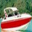

In [10]:
dataset[0][0]

In [11]:
dataset

LITDataset(
    	fold=train,
	length=50000,
	use_extensions=('.png', '.cls'),
	website = https://www.cs.toronto.edu/~kriz/cifar.html,
	num_classes = 10,
	class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'],
	num_train = 50000,
	num_val = 10000,
)